### This notebook is for A Wilde's Project 1 of DATA 71200

# A description of the problem:
Given US Census data, the Current Population Survey, from 2009 with variables about income and work for people 65 and older, I would like to:

**For the supervised project:** develop a model that can predict who is working and who is not

**For the unsupervised project:** determine of those who still working, are there some archetypes or clusters of characteristics that are shared

This notebook is cleaning and preparing the data for the supervised model project.
The data was exported from IPUMS CPS.

## In this notebook:
### 1) Loading the Data
#### Defining the Label 
### 2) Seperating the test set
### 3) Pre-cleaning Visualization
### 4) Cleaning the Data
### 5) Post-cleaning Visualization
### 6) Applying Log and other transformations 
### 7) Final prep - one-hot encoding and standard scaling
#### Remove and one-hot encode the label
#### Apply tranform pipelines to the rest of the 

In [1]:
import pandas as pd
import numpy as np

## 1) Load in the data

In [2]:
seniors_df = pd.read_csv("senior_data_2009_hr_t2.csv")

### Getting a Label: 
- Calculate a combo field from EMPSTAT and WKSTAT 
- Transform to numeric

In [3]:
def combine_EMP_WKSTAT(empstat, wkstat):
    if empstat == "At work":
        if wkstat.find("Full-time") > -1:
            empwkstat = "Full-time"
        elif wkstat.find("Part-time") > -1:
            empwkstat = "Part-time"
        else:
            empwkstat = wkstat
    elif empstat.find("Unemployed") > -1:
            empwkstat = "Unemployed"
    else:
        empwkstat = empstat    
    return empwkstat

In [4]:
seniors_df['EMPWKSTAT'] = seniors_df.apply(lambda row: combine_EMP_WKSTAT(row['EMPSTAT'],row['WKSTAT']),axis=1)
seniors_df['EMPWKSTAT'].value_counts()

NILF, retired                     15865
Full-time                          1756
Part-time                          1715
NILF, unable to work               1084
NILF, other                         547
Unemployed                          225
Has job, not at work last week      210
Name: EMPWKSTAT, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
seniors_empwkstat = seniors_df['EMPWKSTAT']
seniors_empwkstat_encoded = encoder.fit_transform(seniors_empwkstat)
seniors_df['EMPWKSTAT_Num']= pd.DataFrame(seniors_empwkstat_encoded)

In [6]:
seniors_df['EMPWKSTAT_Num'].value_counts()

3    15865
0     1756
5     1715
4     1084
2      547
6      225
1      210
Name: EMPWKSTAT_Num, dtype: int64

## 2) Seperate out a test set
(stratified by employment status)

Adapted from Hands On Machine Learning book

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=17)
for train_index, test_index in split.split(seniors_df, seniors_df['EMPWKSTAT_Num']):
    strat_seniors_train = seniors_df.loc[train_index]
    strat_seniors_test = seniors_df.loc[test_index]

In [8]:
strat_seniors_train['EMPWKSTAT'].value_counts() /len(strat_seniors_train)

NILF, retired                     0.741262
Full-time                         0.082051
Part-time                         0.080120
NILF, unable to work              0.050651
NILF, other                       0.025544
Unemployed                        0.010529
Has job, not at work last week    0.009844
Name: EMPWKSTAT, dtype: float64

In [9]:
strat_seniors_test['EMPWKSTAT'].value_counts() /len(strat_seniors_test)

NILF, retired                     0.741357
Full-time                         0.082041
Part-time                         0.080172
NILF, unable to work              0.050645
NILF, other                       0.025603
Unemployed                        0.010465
Has job, not at work last week    0.009718
Name: EMPWKSTAT, dtype: float64

## 3) Initial visualization 
before cleaning

In [10]:
strat_seniors_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16051 entries, 12098 to 8036
Data columns (total 51 columns):
OWNERSHP             16051 non-null object
HOUSRET              16051 non-null float64
PUBHOUS              2828 non-null object
RENTSUB              2288 non-null object
CPSIDP               16051 non-null float64
AGE                  16051 non-null int64
SEX                  16051 non-null object
RACE                 16051 non-null object
MARST                16051 non-null object
YRIMMIG              2203 non-null object
CITIZEN              16051 non-null object
HISPAN               1451 non-null object
EMPSTAT              16051 non-null object
OCC                  15390 non-null object
IND                  16051 non-null object
CLASSWKR             3021 non-null object
UHRSWORKT            439 non-null object
WKSTAT               16051 non-null object
EDUC                 16051 non-null object
WKSWORK1             16051 non-null float64
WHYPTLY              1761 non-nul

In [11]:
strat_seniors_train.describe()

,HOUSRET,CPSIDP,AGE,WKSWORK1,FTOTVAL,INCTOT,INCSS,INCWELFR,INCRETIR,INCSSI,...,TAXINC,HOURWAGE,ratio_tax_income,all_wages,multi_jobs,all_business_farm,all_disability,all_survivor,reported_inc_diff,EMPWKSTAT_Num
count,16051.000000,1.605100e+04,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000,...,16051.000000,259.000000,16051.000000,16051.000000,16051.000000,16051.000000,16051.000000,25.000000,16051.000000,16051.000000
mean,5943.476917,1.674741e+13,73.826802,9.176687,51180.211763,27814.623076,10712.341163,3.892655,4909.073329,161.202043,...,11297.285527,1394.100386,0.139802,6433.169771,0.013956,1372.761386,76.465392,19688.920000,16517.337549,2.951093
std,5593.253670,7.474500e+12,6.268164,18.957455,56408.334839,36255.437257,7481.285782,125.606710,11642.510935,1109.485688,...,25062.557543,901.753768,0.266877,26213.002975,0.117310,15216.947763,1607.916458,12834.586894,29574.191039,1.125590
min,-9999.000000,0.000000e+00,65.000000,0.000000,-4710.000000,-6999.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,325.000000,0.000000,0.000000,0.000000,-18000.000000,0.000000,3568.000000,-99997.000000,0.000000
25%,1291.000000,2.007121e+13,68.000000,0.000000,18784.000000,10200.000000,6056.500000,0.000000,0.000000,0.000000,...,0.000000,875.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10440.000000,7994.500000,3.000000
50%,4556.000000,2.008030e+13,73.000000,0.000000,34117.000000,17230.000000,10757.000000,0.000000,0.000000,0.000000,...,0.000000,1200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17343.000000,13457.000000,3.000000
75%,9339.000000,2.009011e+13,80.000000,0.000000,63964.500000,32278.000000,15149.000000,0.000000,3228.000000,0.000000,...,4648.000000,1502.000000,0.117014,0.000000,0.000000,0.000000,0.000000,26772.000000,21702.000000,3.000000
max,17405.000000,2.009031e+13,85.000000,52.000000,981569.000000,594386.000000,50000.000000,7200.000000,106126.000000,19632.000000,...,99997.000000,6000.000000,1.000000,449599.000000,1.000000,489599.000000,90607.000000,60000.000000,494389.000000,6.000000


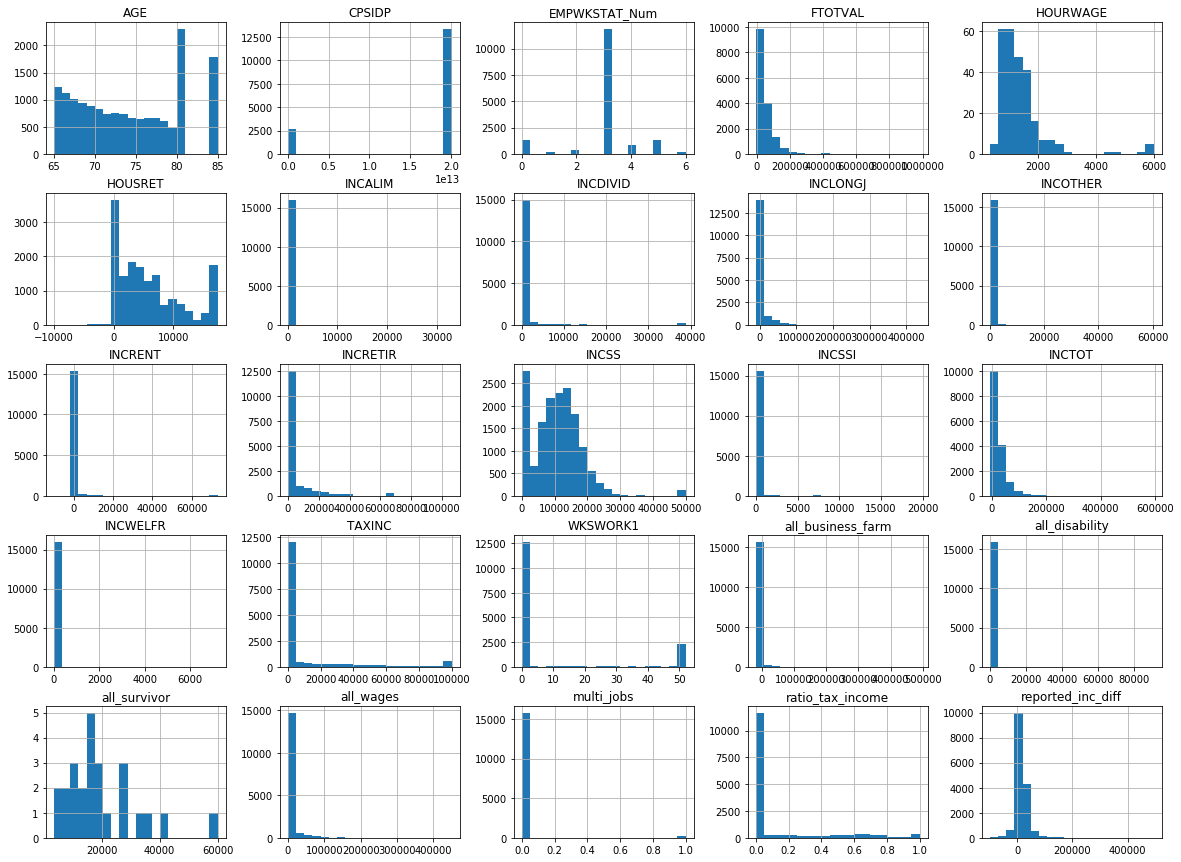

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt 
strat_seniors_train.hist(bins=20, figsize=(20,15)) 
plt.show()

### Visualizing INCRETIR and INCSS by Employment status (label)

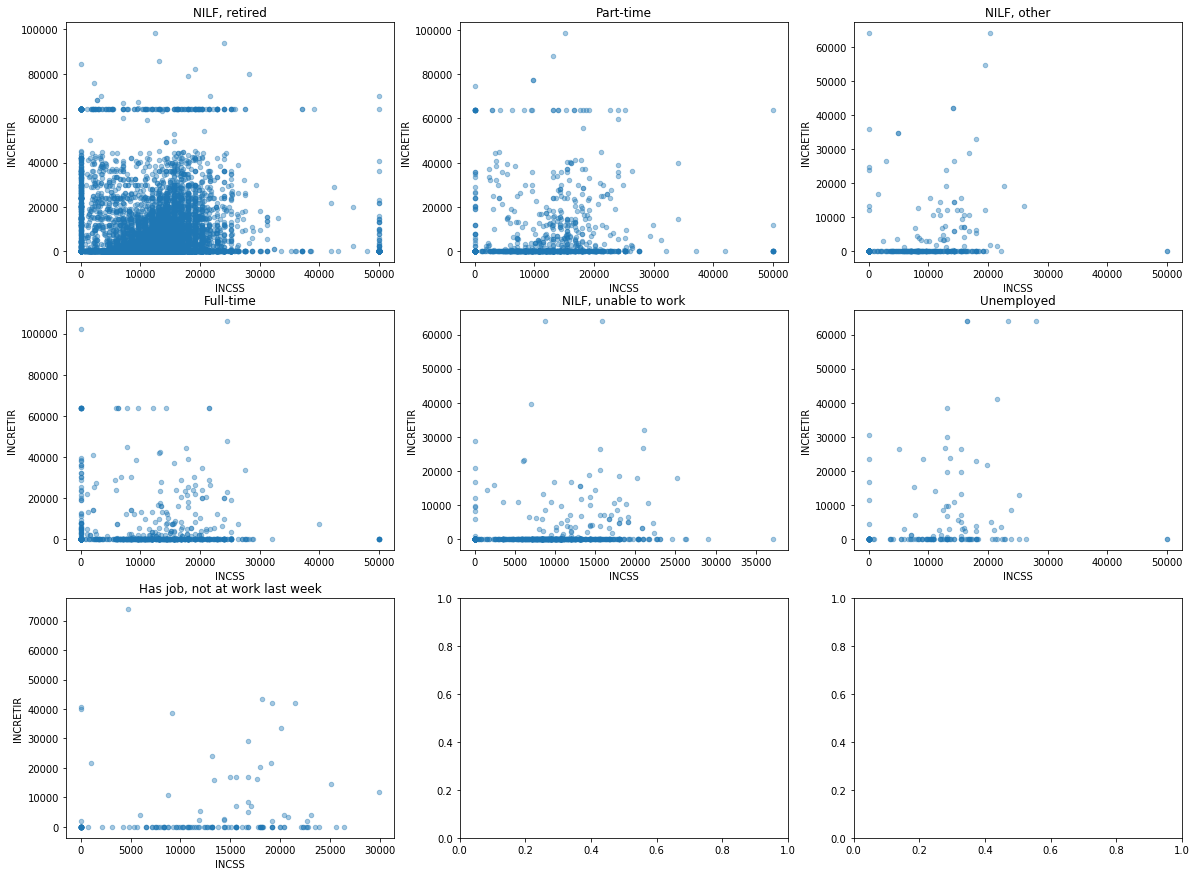

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,15))
x = 0
y = 0
for status in strat_seniors_train["EMPWKSTAT"].unique():
    strat_seniors_train[strat_seniors_train["EMPWKSTAT"] == status].plot(kind="scatter", x="INCSS", y="INCRETIR", alpha=0.4, ax=axes[x,y])
    axes[x,y].set_title(status)
    if y < 2 :
        y = y + 1
    elif y == 2 :
        y = 0
        x = x + 1

## 4) Data Cleaning
- Calculating New Values
- Dropping correlated values
- Handling Nulls

The following for calculating new valueswas adapted from the book *Hands-on Machine Learning* Chapter 2

#### Combining Attributes 
- for citizen percent of life **note this uses a hardcoded year value for this data (From 2009)**
- total passive income

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
# Class to combine attributes for Percent of Life one was Citizen and Total Passive Income
# Instantiation 
#   Input: 2 boolean values to add the two columns
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame 
class DF_CombinedAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,add_citizen_percent_of_life = True, add_total_passive_inc = True):
        self.add_citizen_percent_of_life = add_citizen_percent_of_life
        self.add_total_passive_inc = add_total_passive_inc
    def fit(self, X, y = None):
        return self # nothing to do on fit
    def transform(self, X_df, y = None):
        #X is a data frame
        X_df_copy = X_df.copy(deep=True)
        if self.add_citizen_percent_of_life:
            X_df_copy['percent_of_life']=X_df_copy.apply(lambda row: (2009-int(row['YRIMMIG'][0:4]))/int(row['AGE']) if not pd.isna(row['YRIMMIG']) else 1,axis = 1)
        if self.add_total_passive_inc:
            X_df_copy['passive_inc'] = X_df_copy.apply(lambda row: row['INCTOT']-row['all_wages']-row['all_business_farm'],axis = 1)
        return X_df_copy

In [16]:
#test it
#adder = DF_CombinedAttributesTransformer()
#strat_seniors_train_combined_attribs = adder.transform(strat_seniors_train)
#strat_seniors_train_combined_attribs['percent_of_life'].value_counts()

### Transformer for Dropping The Unnecssary Columns
This is also adapted from *Hands-on Machine Learning* Chapter 2

In [17]:
# Class to drop attributes
# Instantiation 
#   Input: a list of the columns to drop
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame - the dropped columns
class DF_DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df.drop(columns = self.columns_to_drop)

In [18]:
#test dropping class transformer
#dropper = DF_DropColumnsTransformer(['INCTOT', 'all_wages', 'INCLONGJ'])
#strat_seniors_train_combined_attribs_thinned = dropper.transform(strat_seniors_train_combined_attribs)
#strat_seniors_train_combined_attribs_thinned.columns

### Class to address null values in the following remaining columns

In [19]:
null_counts = {}
for column in strat_seniors_train.columns:
    count = strat_seniors_train[column].isnull().sum()
    if count != 0:
        null_counts[column]= count
null_counts

{'PUBHOUS': 13223,
 'RENTSUB': 13763,
 'YRIMMIG': 13848,
 'HISPAN': 14600,
 'OCC': 661,
 'CLASSWKR': 13030,
 'UHRSWORKT': 15612,
 'WHYPTLY': 14290,
 'SRCRETI1': 11166,
 'SRCRETI2': 15894,
 'SRCEARN': 12626,
 'GOTVDISA': 15603,
 'GOTVOTHE': 15603,
 'GOTVPENS': 15603,
 'GOTVSURV': 15603,
 'HOURWAGE': 15792,
 'UNION': 15627,
 'all_survivor': 16026}

In [20]:
# Object of the keys and appropriate null values
null_values = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

In [21]:
# Class to replace null values in given columns
# Instantiation 
#   Input: an object of the column names and their associated null value replacements
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_ReplaceNullValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, null_value_replacements):
        self.null_value_replacements = null_value_replacements
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for key, value in self.null_value_replacements.items():
            X_df_copy[key]=X_df_copy[key].apply(lambda x: value if pd.isna(x) else x)
        return X_df_copy

In [22]:
#test replace null values Transformer
#null_replacer = DF_ReplaceNullValuesTransformer(null_values)
#strat_seniors_train_combined_attribs_thinned_replaced = null_replacer.transform(strat_seniors_train_combined_attribs_thinned)
#null_counts = {}
#for column in strat_seniors_train_combined_attribs_thinned_replaced.columns:
#    count = strat_seniors_train_combined_attribs_thinned_replaced[column].isnull().sum()
#    if count != 0:
#        null_counts[column]= count
#null_counts

### Pipeline of these Cleaning Steps
- DF_CombinedAttributesTransformer
- DF_DropColumnsTransformer
- DF_ReplaceNullValuesTransformer

Define the real values for: 
- Columns to drop
- null value replacements

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
# list of columns to drop:
columns_to_drop = ['FTOTVAL','INCTOT','INCOTHER','INCLONGJ','WKSWORK1','WHYPTLY','TAXINC','HOURWAGE','UNION',
                   'reported_inc_diff','all_wages','CLASSWKR','UHRSWORKT','SRCEARN','ratio_tax_income','multi_jobs',
                   'YRIMMIG','OCC','IND','CPSIDP','EMPSTAT','WKSTAT']

# Object of the keys and appropriate null value replacements
null_value_replacements = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

#### Run the Pipeline

In [25]:
df_cleaning_pipeline = Pipeline([
    ('combiner',DF_CombinedAttributesTransformer()),
    ('dropper',DF_DropColumnsTransformer(columns_to_drop)),
    ('null_replacer',DF_ReplaceNullValuesTransformer(null_value_replacements))
])
strat_seniors_train_cleaned = df_cleaning_pipeline.fit_transform(strat_seniors_train)
strat_seniors_test_cleaned = df_cleaning_pipeline.fit_transform(strat_seniors_test)

## 5) Looking at the cleaned data
Fewer features - cutting out all info about wage income and reducing others

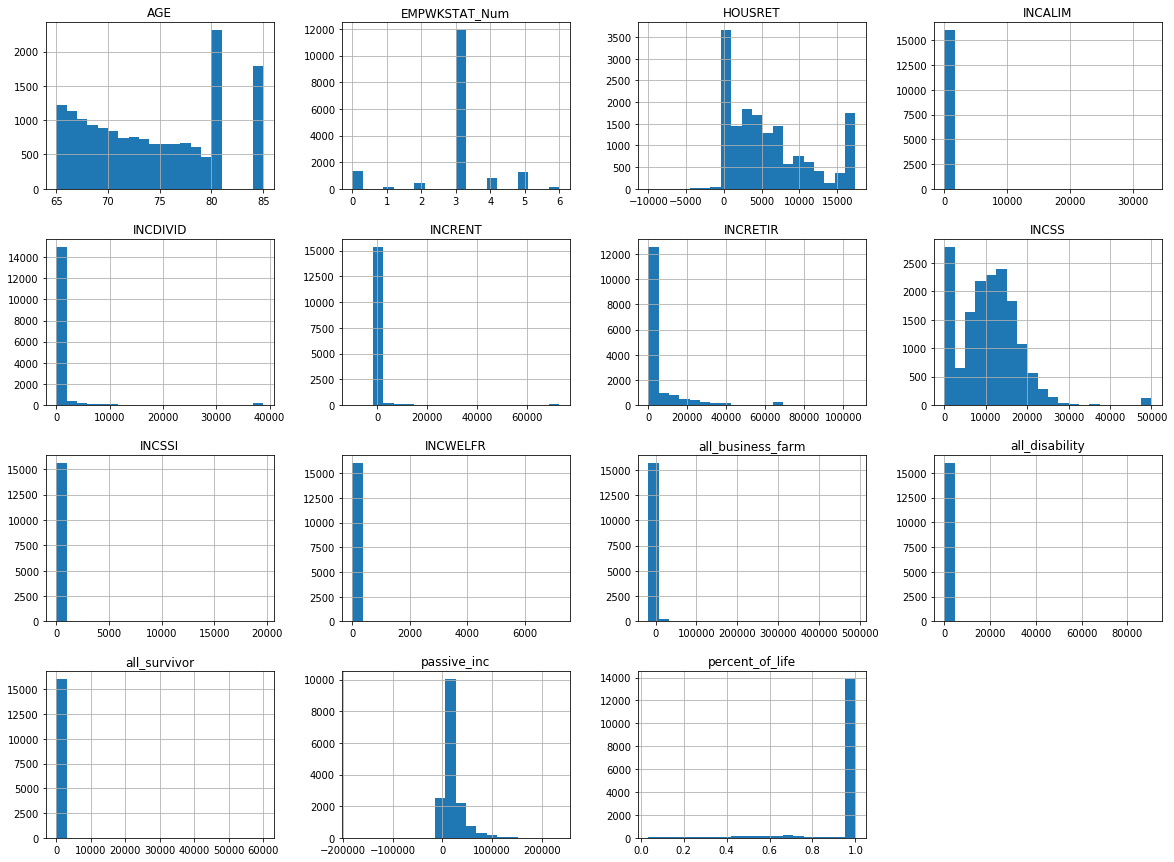

In [26]:
strat_seniors_train_cleaned.hist(bins=20, figsize=(20,15)) 
plt.show()

### Checking correlation on the label value

In [27]:
corr_matrix = strat_seniors_train_cleaned.corr()

In [28]:
corr_matrix['EMPWKSTAT_Num'].sort_values(ascending=False)

EMPWKSTAT_Num        1.000000
INCSS                0.101039
AGE                  0.078657
passive_inc          0.070495
INCSSI               0.046636
percent_of_life      0.041326
INCRETIR             0.037133
INCALIM              0.011078
all_disability       0.008916
INCDIVID             0.005585
all_survivor         0.002481
INCWELFR            -0.005785
INCRENT             -0.035101
HOUSRET             -0.040072
all_business_farm   -0.100131
Name: EMPWKSTAT_Num, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a7a17f0>,
      dtype=object)

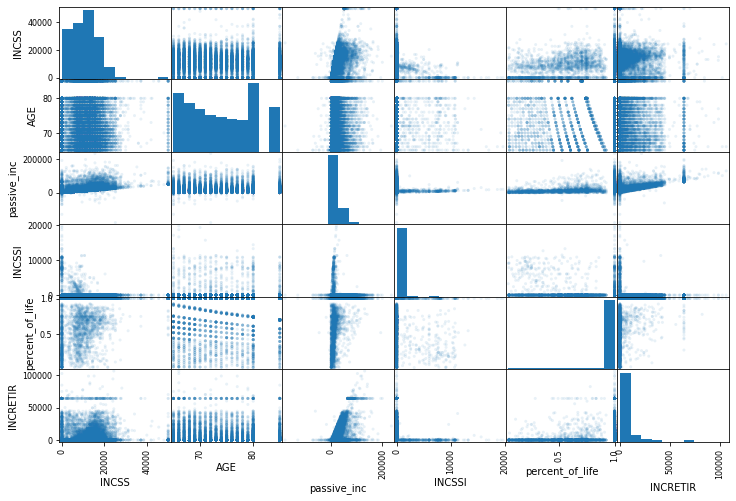

In [29]:
from pandas.plotting import scatter_matrix
attributes = ["INCSS", "AGE", "passive_inc",
              "INCSSI","percent_of_life","INCRETIR"]
scatter_matrix(strat_seniors_train_cleaned[attributes], figsize=(12, 8), alpha=0.1)

## 6) Applying logorithmic transforms to data 
because this is useful

Other transforms below, but not used

In [30]:
log_column_list=['INCDIVID','INCRETIR']

In [31]:
# Class to apply logorithmic scaling to a given list of columns
# Instantiation 
#   Input: a list of columns to scale logorithmically
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_GetLogValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_log):
        self.columns_to_log = columns_to_log
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for column in self.columns_to_log:
            X_df_copy[column]=X_df_copy[column].apply(lambda x: np.log(x+1))
        return X_df_copy

In [32]:
get_logs = DF_GetLogValuesTransformer(log_column_list)
strat_seniors_train_cleaned_log = get_logs.fit_transform(strat_seniors_train_cleaned)
strat_seniors_test_cleaned_log = get_logs.fit_transform(strat_seniors_test_cleaned)
strat_seniors_train_cleaned_log.shape

(16051, 31)

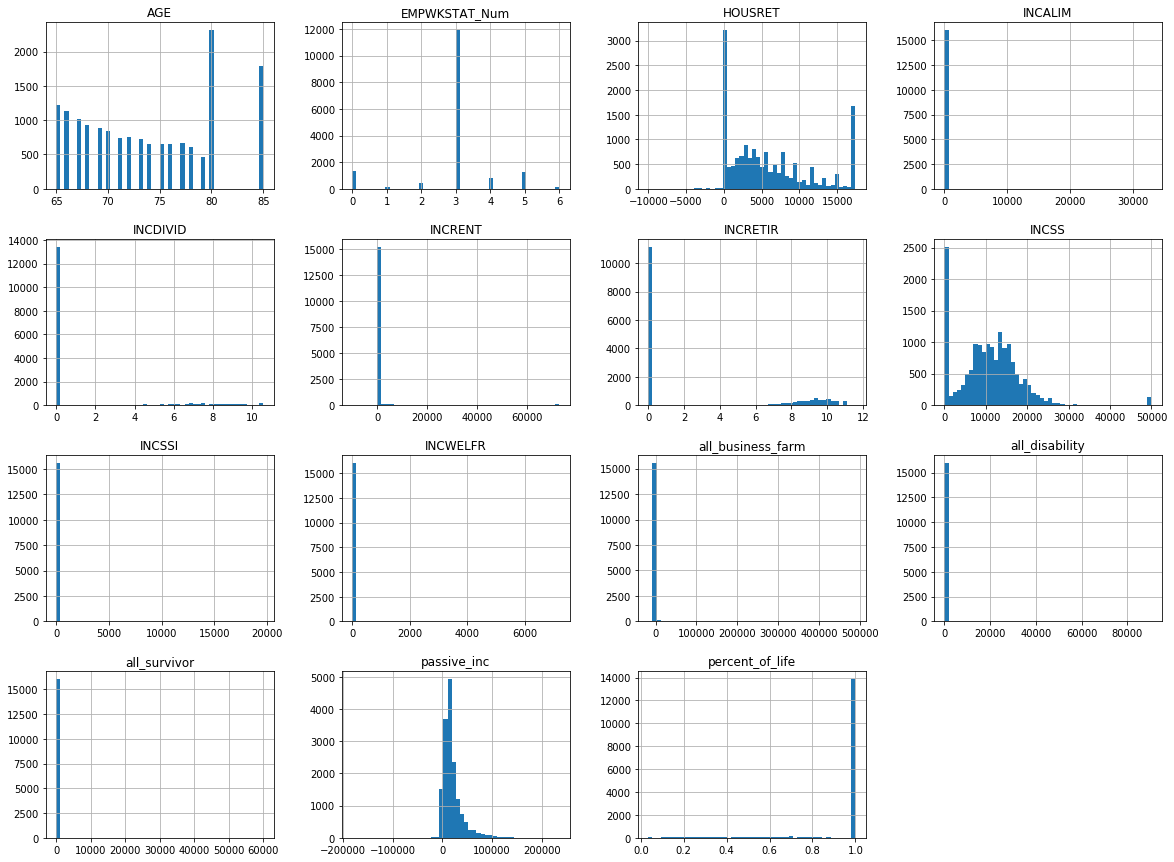

In [33]:
strat_seniors_train_cleaned_log.hist(bins=50, figsize=(20,15)) 
plt.show()

### Other required transformations: 
- squaring
- cubing
- exponential

Not determined to be useful

In [34]:
transform_list =['INCDIVID','INCRETIR']
# copy the columns for the transformations
transform_df=strat_seniors_train_cleaned[transform_list]
transform_df.describe()

,INCDIVID,INCRETIR
count,16051.000000,16051.000000
mean,883.187278,4909.073329
std,4668.489439,11642.510935
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,3228.000000
max,38815.000000,106126.000000


#### Square the values

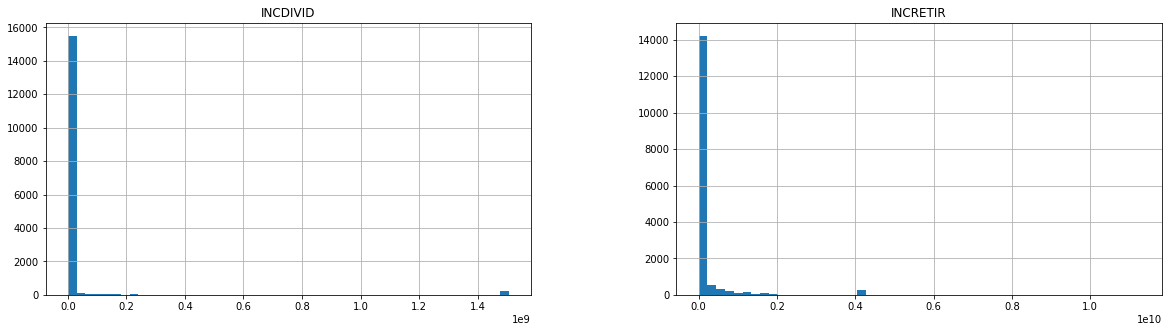

In [35]:
transform_df_squared=transform_df ** 2
transform_df_squared.hist(bins=50, figsize=(20,5)) 
plt.show()

#### Cube the values

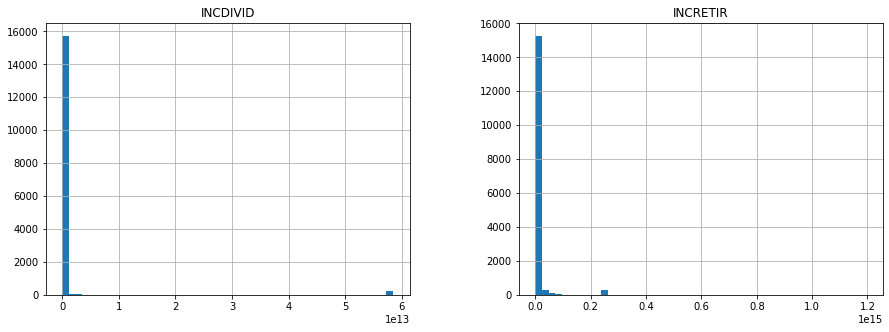

In [36]:
transform_df_cubed=transform_df ** 3
transform_df_cubed.hist(bins=50, figsize=(15,5)) 
plt.show()

#### Exponetiate the values 
(with some scaling to avoid infinite values due to double point floating numbers max)

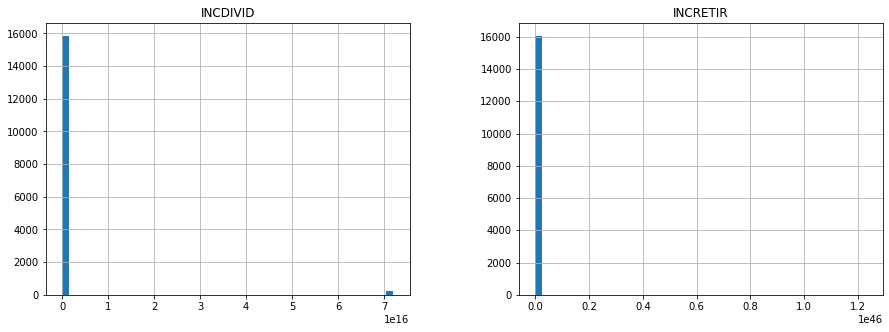

In [37]:
transform_df_exp=np.exp(transform_df/1000)
transform_df_exp.hist(bins=50, figsize=(15,5)) 
plt.show()

## 7) Final Cleaning of Data: One-hot encoding and standard scaling
Adapted from the book *Hands-on Machine Learning* Chapter 2

### First Seperate the labels and One-hot encode them

In [38]:
# Seperate out the labels
# Instantiation 
#   Input: the label column
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: Dataframe without the labels, NP array of the labels
class DF_NP_Cat_Label_Seperator(BaseEstimator, TransformerMixin):
    def __init__(self, label_column):
        self.label_column = label_column
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        labels_np = X_df[self.label_column].to_numpy()
        X_df_no_labels = X_df.drop(columns=self.label_column)
        return X_df_no_labels, labels_np

In [39]:
label_seperator = DF_NP_Cat_Label_Seperator('EMPWKSTAT')
strat_seniors_train_cleaned_log_nol, train_labels = label_seperator.transform(strat_seniors_train_cleaned_log)
strat_seniors_test_cleaned_log_nol, test_labels = label_seperator.transform(strat_seniors_test_cleaned_log) 

#### Drop the label Num value used in earlier visualizations

In [40]:
strat_seniors_train_cleaned_log_nol=strat_seniors_train_cleaned_log_nol.drop(columns='EMPWKSTAT_Num')
strat_seniors_test_cleaned_log_nol=strat_seniors_test_cleaned_log_nol.drop(columns='EMPWKSTAT_Num')


In [41]:
strat_seniors_train_cleaned_log_nol.shape

(16051, 29)

In [42]:
strat_seniors_test_cleaned_log_nol.shape

(5351, 29)

#### One-hot encode the labels

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [44]:
train_labels_1hot = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_1hot = encoder.fit_transform(test_labels.reshape(-1,1))

### On to Attribute One-hot and Standard Scaling
Adapted from *Hands-on Machine Learning* Chapter 2

In [45]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

In [46]:
# define columns for numeric vs categorical pipelines
numeric_columns = ['HOUSRET','AGE','INCSS','INCWELFR','INCRETIR','INCSSI','INCDIVID','INCALIM','all_business_farm',
                   'all_disability','all_survivor','percent_of_life','passive_inc']
categor_columns = ['OWNERSHP','PUBHOUS','RENTSUB','SEX','RACE','MARST','CITIZEN','HISPAN','EDUC','SRCRETI1',
                  'SRCRETI2','GOTVDISA','GOTVOTHE','GOTVPENS','GOTVSURV']

In [47]:
# Helper transformer to seperate out the given columns of a DataFrame
# Instantiation 
#   Input: a list of the columns to select
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: NP Array with just the selected columns
class DF_NP_Column_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select):
        self.columns_to_select = columns_to_select
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df[self.columns_to_select].to_numpy()

In [48]:
numeric_pipeline = Pipeline([
    ('selector', DF_NP_Column_Selector(numeric_columns)),
    ('std_scaler', StandardScaler())
])

In [49]:
categor_pipeline= Pipeline([
    ('selector', DF_NP_Column_Selector(categor_columns)),
    ('1hot_encoder', OneHotEncoder())
])

In [50]:
full_scale_1hot_pipeline=FeatureUnion(
    transformer_list=[
        ('numeric_pipeline', numeric_pipeline),
        ('categor_pipeline', categor_pipeline)])

In [51]:
seniors_train_prepared = full_scale_1hot_pipeline.fit_transform(strat_seniors_train_cleaned_log_nol)
seniors_test_prepared = full_scale_1hot_pipeline.fit_transform(strat_seniors_test_cleaned_log_nol)


In [52]:
seniors_train_prepared.shape

(16051, 99)